# 5. Exploratory Analysis
## Set Up Environment
**Go [here](01_import_data.ipynb) if you are following along and have not configured the virtual environment and installed dependencies.**

In [8]:
# Jupyter magic
%run ../util/dependencies.py
%load_ext sql

## ATA/JASC - What systems are failing the most?
### ATA Chapters causing safety failures and grounding

In [ ]:
-- Highest ata_chapter safety discrepencies
SELECT a.ata_chapter, a.description, count(DISTINCT s.operator_control_number) AS discrepancies
FROM sdr_event AS s
INNER JOIN jasc_code AS j
    ON j.jasc_code = s.jasc_code
INNER JOIN ata_chapter AS a
    ON a.ata_chapter = j.ata_chapter
GROUP BY a.ata_chapter, a.description
ORDER BY discrepancies DESC;

-- Highest ata_chapter safety discrepencies
-- GROUNDING
SELECT a.ata_chapter, a.description, count(DISTINCT s.operator_control_number) AS grounding_discrepancies
FROM sdr_event AS s
INNER JOIN jasc_code AS j
    ON j.jasc_code = s.jasc_code
INNER JOIN ata_chapter AS a
    ON a.ata_chapter = j.ata_chapter
WHERE s.aog_flag = TRUE
GROUP BY a.ata_chapter, a.description
ORDER BY grounding_discrepancies DESC;

-- AOG/System Safety Failure Rate
-- (How often are systems failing where they result in grounding?)
WITH aog_rate_table AS (
    SELECT a.ata_chapter, a.description, AVG(s.aog_flag::int) AS aog_rate, count(s.aog_flag) total_writeups
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    INNER JOIN ata_chapter AS a
        ON a.ata_chapter = j.ata_chapter
    GROUP BY a.ata_chapter
)

SELECT *
FROM aog_rate_table
ORDER BY aog_rate DESC;

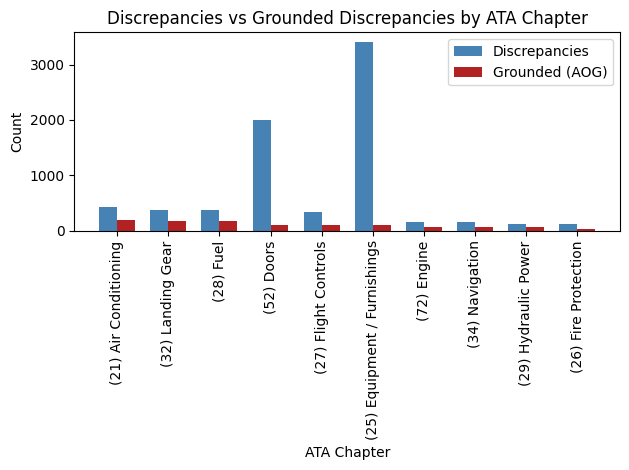

[0 1 2 3 4 5 6 7 8 9]


In [25]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(".."))
from util import sql_python_interface as interface

my_df = interface.q_to_df("""
    -- Highest ata_chapter safety discrepencies
    SELECT a.ata_chapter::varchar, a.description, count(DISTINCT s.operator_control_number) AS discrepancies, SUM(s.aog_flag::int) AS grounding_discrepancies
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    INNER JOIN ata_chapter AS a
        ON a.ata_chapter = j.ata_chapter
    GROUP BY a.ata_chapter, a.description
    ORDER BY grounding_discrepancies DESC
    LIMIT 10;
""")

x = np.arange(len(my_df))  # positions for each ATA chapter
width = 0.35            # width of each bar

plt.bar(x - width/2, my_df['discrepancies'], width, label='Discrepancies', color='steelblue')
plt.bar(x + width/2, my_df['grounding_discrepancies'], width, label='Grounded (AOG)', color='firebrick')

plt.xticks(x, '(' + my_df['ata_chapter'] + ') ' + my_df['description'], rotation=90)
plt.xlabel("ATA Chapter")
plt.ylabel("Count")
plt.title("Discrepancies vs Grounded Discrepancies by ATA Chapter")
plt.legend()

plt.tight_layout()
plt.show()
print(x)


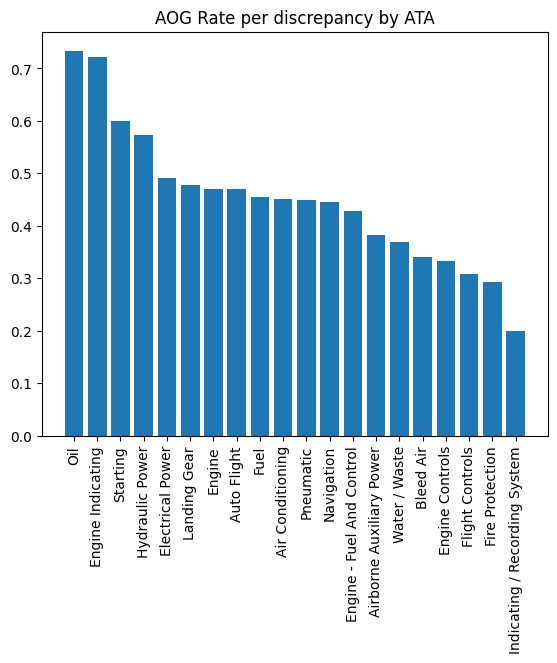

In [27]:
from util import sql_python_interface as interface

my_df = interface.q_to_df("""
    -- AOG/System Safety Failure Rate
    -- (How often are systems failing where they result in grounding?)
    WITH aog_rate_table AS (
        SELECT a.ata_chapter, a.description, AVG(s.aog_flag::int) AS aog_rate, count(s.aog_flag) total_writeups
        FROM sdr_event AS s
        INNER JOIN jasc_code AS j
            ON j.jasc_code = s.jasc_code
        INNER JOIN ata_chapter AS a
            ON a.ata_chapter = j.ata_chapter
        GROUP BY a.ata_chapter
    )

    SELECT *
    FROM aog_rate_table
    ORDER BY aog_rate DESC
    LIMIT 20;
""")

plt.bar(x=my_df['description'], height=my_df['aog_rate'])
plt.title('AOG Rate per discrepancy by ATA')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

### JASCs causing safety failures and grounding

In [ ]:
-- Determine highest ata_chapters discrepency occurances
SELECT j.jasc_code, j.description, count(DISTINCT s.operator_control_number) AS discrepancies
FROM sdr_event AS s
INNER JOIN jasc_code AS j
    ON j.jasc_code = s.jasc_code
GROUP BY j.jasc_code, j.description
ORDER BY discrepancies DESC;

-- Determine highest ata_chapters discrepency occurances
-- BY GROUNDING
SELECT j.jasc_code, j.description, count(DISTINCT s.operator_control_number) AS grounding_discrepancies
FROM sdr_event AS s
INNER JOIN jasc_code AS j
    ON j.jasc_code = s.jasc_code
WHERE s.aog_flag = True
GROUP BY j.jasc_code, j.description
ORDER BY grounding_discrepancies DESC;

-- AOG/Subsystem Safety Failure Rate
-- (How often are subsystems failing where they result in grounding?)
WITH aog_rate_table AS (
    SELECT j.jasc_code, j.description, AVG(s.aog_flag::int) AS aog_rate, COUNT(s.aog_flag) AS total_writeups
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    GROUP BY j.jasc_code
)

SELECT *
FROM aog_rate_table
ORDER BY aog_rate DESC;

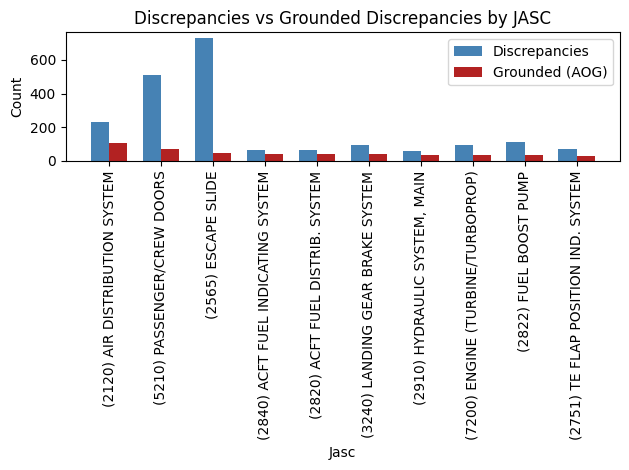

[0 1 2 3 4 5 6 7 8 9]


In [28]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(".."))
from util import sql_python_interface as interface

my_df = interface.q_to_df("""
    -- Highest ata_chapter safety discrepencies
    SELECT j.jasc_code::varchar, j.description, count(DISTINCT s.operator_control_number) AS discrepancies, SUM(s.aog_flag::int) AS grounding_discrepancies
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    GROUP BY j.jasc_code, j.description
    ORDER BY grounding_discrepancies DESC
    LIMIT 10;
""")

x = np.arange(len(my_df))  # positions for each ATA chapter
width = 0.35            # width of each bar

plt.bar(x - width/2, my_df['discrepancies'], width, label='Discrepancies', color='steelblue')
plt.bar(x + width/2, my_df['grounding_discrepancies'], width, label='Grounded (AOG)', color='firebrick')

plt.xticks(x, '(' + my_df['jasc_code'] + ') ' + my_df['description'], rotation=90)
plt.xlabel("Jasc")
plt.ylabel("Count")
plt.title("Discrepancies vs Grounded Discrepancies by JASC")
plt.legend()

plt.tight_layout()
plt.show()
print(x)


## Trend Analysis
### Events per month by ATA and JASC

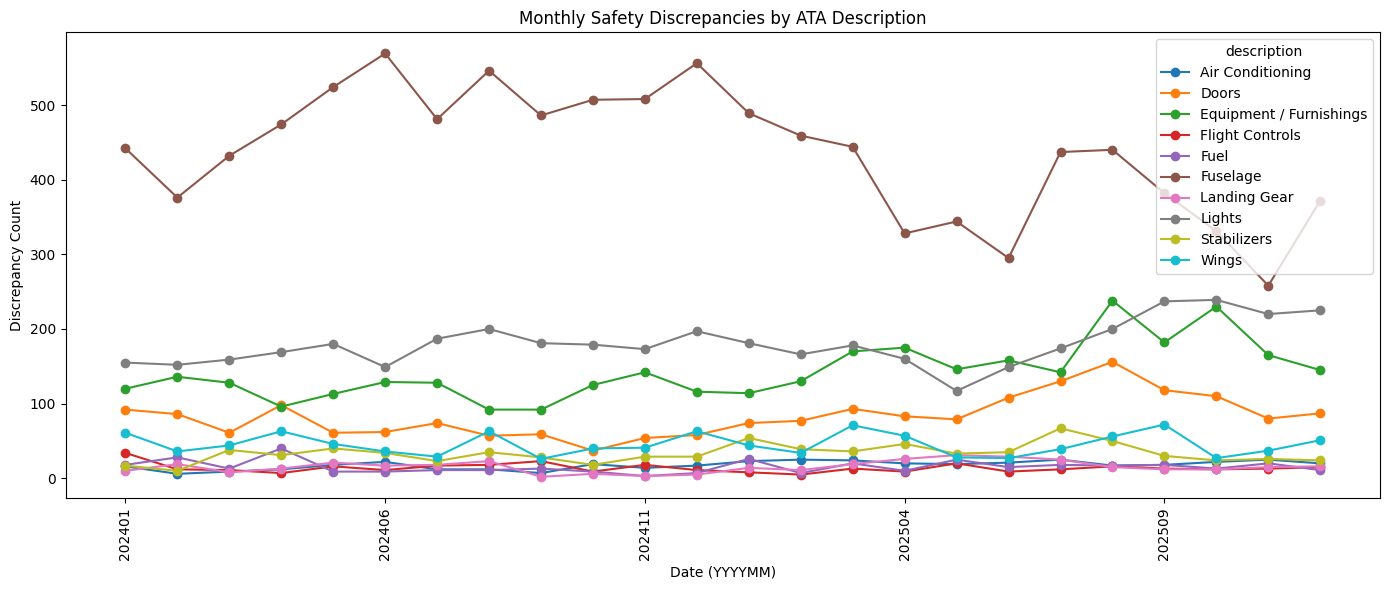

In [48]:
my_df = interface.q_to_df("""
    WITH monthly_counts AS (
    SELECT 
        a.description,
        TO_CHAR(s.difficulty_date, 'YYYYMM') AS date,
        COUNT(s.operator_control_number) AS count
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    INNER JOIN ata_chapter AS a
        ON j.ata_chapter = a.ata_chapter
    GROUP BY a.description, date
),

total_counts AS (
    SELECT 
        description,
        SUM(count) AS total_count
    FROM monthly_counts
    GROUP BY description
),

top_descriptions AS (
    SELECT 
        description
    FROM total_counts
    ORDER BY total_count DESC
    LIMIT 10
)

SELECT 
    m.description,
    m.date,
    m.count
FROM monthly_counts AS m
WHERE m.description IN (SELECT description FROM top_descriptions)
ORDER BY m.date ASC, m.count DESC;
""")


pivot_df = my_df.pivot(
    index='date',
    columns='description',
    values='count'
)

pivot_df.plot(
    figsize=(14, 6),
    marker='o'
)

plt.title("Monthly Safety Discrepancies by ATA Description")
plt.xlabel("Date (YYYYMM)")
plt.ylabel("Discrepancy Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### AOG events over time

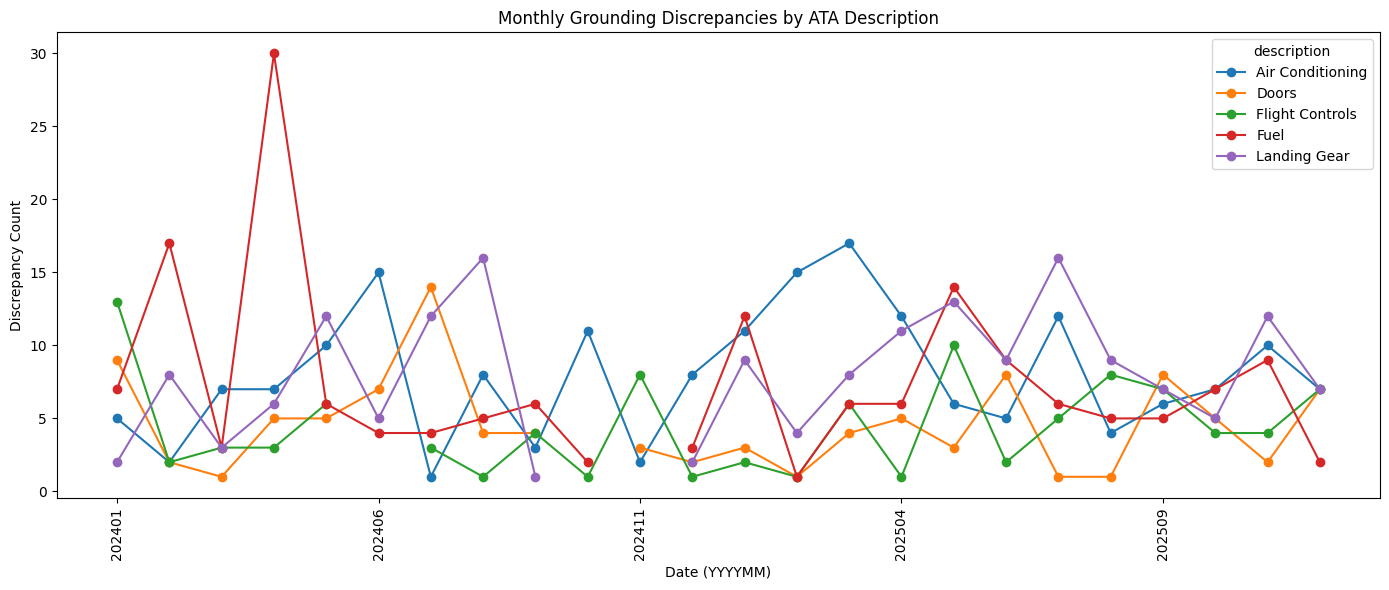

In [52]:
my_df = interface.q_to_df("""
    WITH monthly_counts AS (
    SELECT 
        a.description,
        TO_CHAR(s.difficulty_date, 'YYYYMM') AS date,
        COUNT(s.operator_control_number) AS count
    FROM sdr_event AS s
    INNER JOIN jasc_code AS j
        ON j.jasc_code = s.jasc_code
    INNER JOIN ata_chapter AS a
        ON j.ata_chapter = a.ata_chapter
    WHERE aog_flag::int = 1
    GROUP BY a.description, date
),

total_counts AS (
    SELECT 
        description,
        SUM(count) AS total_count
    FROM monthly_counts
    GROUP BY description
),

top_descriptions AS (
    SELECT 
        description
    FROM total_counts
    ORDER BY total_count DESC
    LIMIT 5
)

SELECT 
    m.description,
    m.date,
    m.count
FROM monthly_counts AS m
WHERE m.description IN (SELECT description FROM top_descriptions)
ORDER BY m.date ASC, m.count DESC;
""")


pivot_df = my_df.pivot(
    index='date',
    columns='description',
    values='count'
)

pivot_df.plot(
    figsize=(14, 6),
    marker='o'
)

plt.title("Monthly Grounding Discrepancies by ATA Description")
plt.xlabel("Date (YYYYMM)")
plt.ylabel("Discrepancy Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Failure Mode Analysis
### Keyword frequency

### Keyword x ATA Heatmap

In [ ]:
SELECT 
    j.ata_chapter,
    COUNT(*) AS sdr_count
FROM sdr_event AS s
JOIN jasc_code AS j ON j.jasc_code = s.jasc_code
GROUP BY j.ata_chapter
ORDER BY j.ata_chapter;

SELECT 
    a.description,
    COUNT(*) 
FROM ata_chapter AS a
GROUP BY a.description
ORDER BY a.description;

SELECT DISTINCT
    a.ata_chapter,
    '"' || a.description || '"' AS desc_with_quotes
FROM ata_chapter AS a
ORDER BY a.ata_chapter;


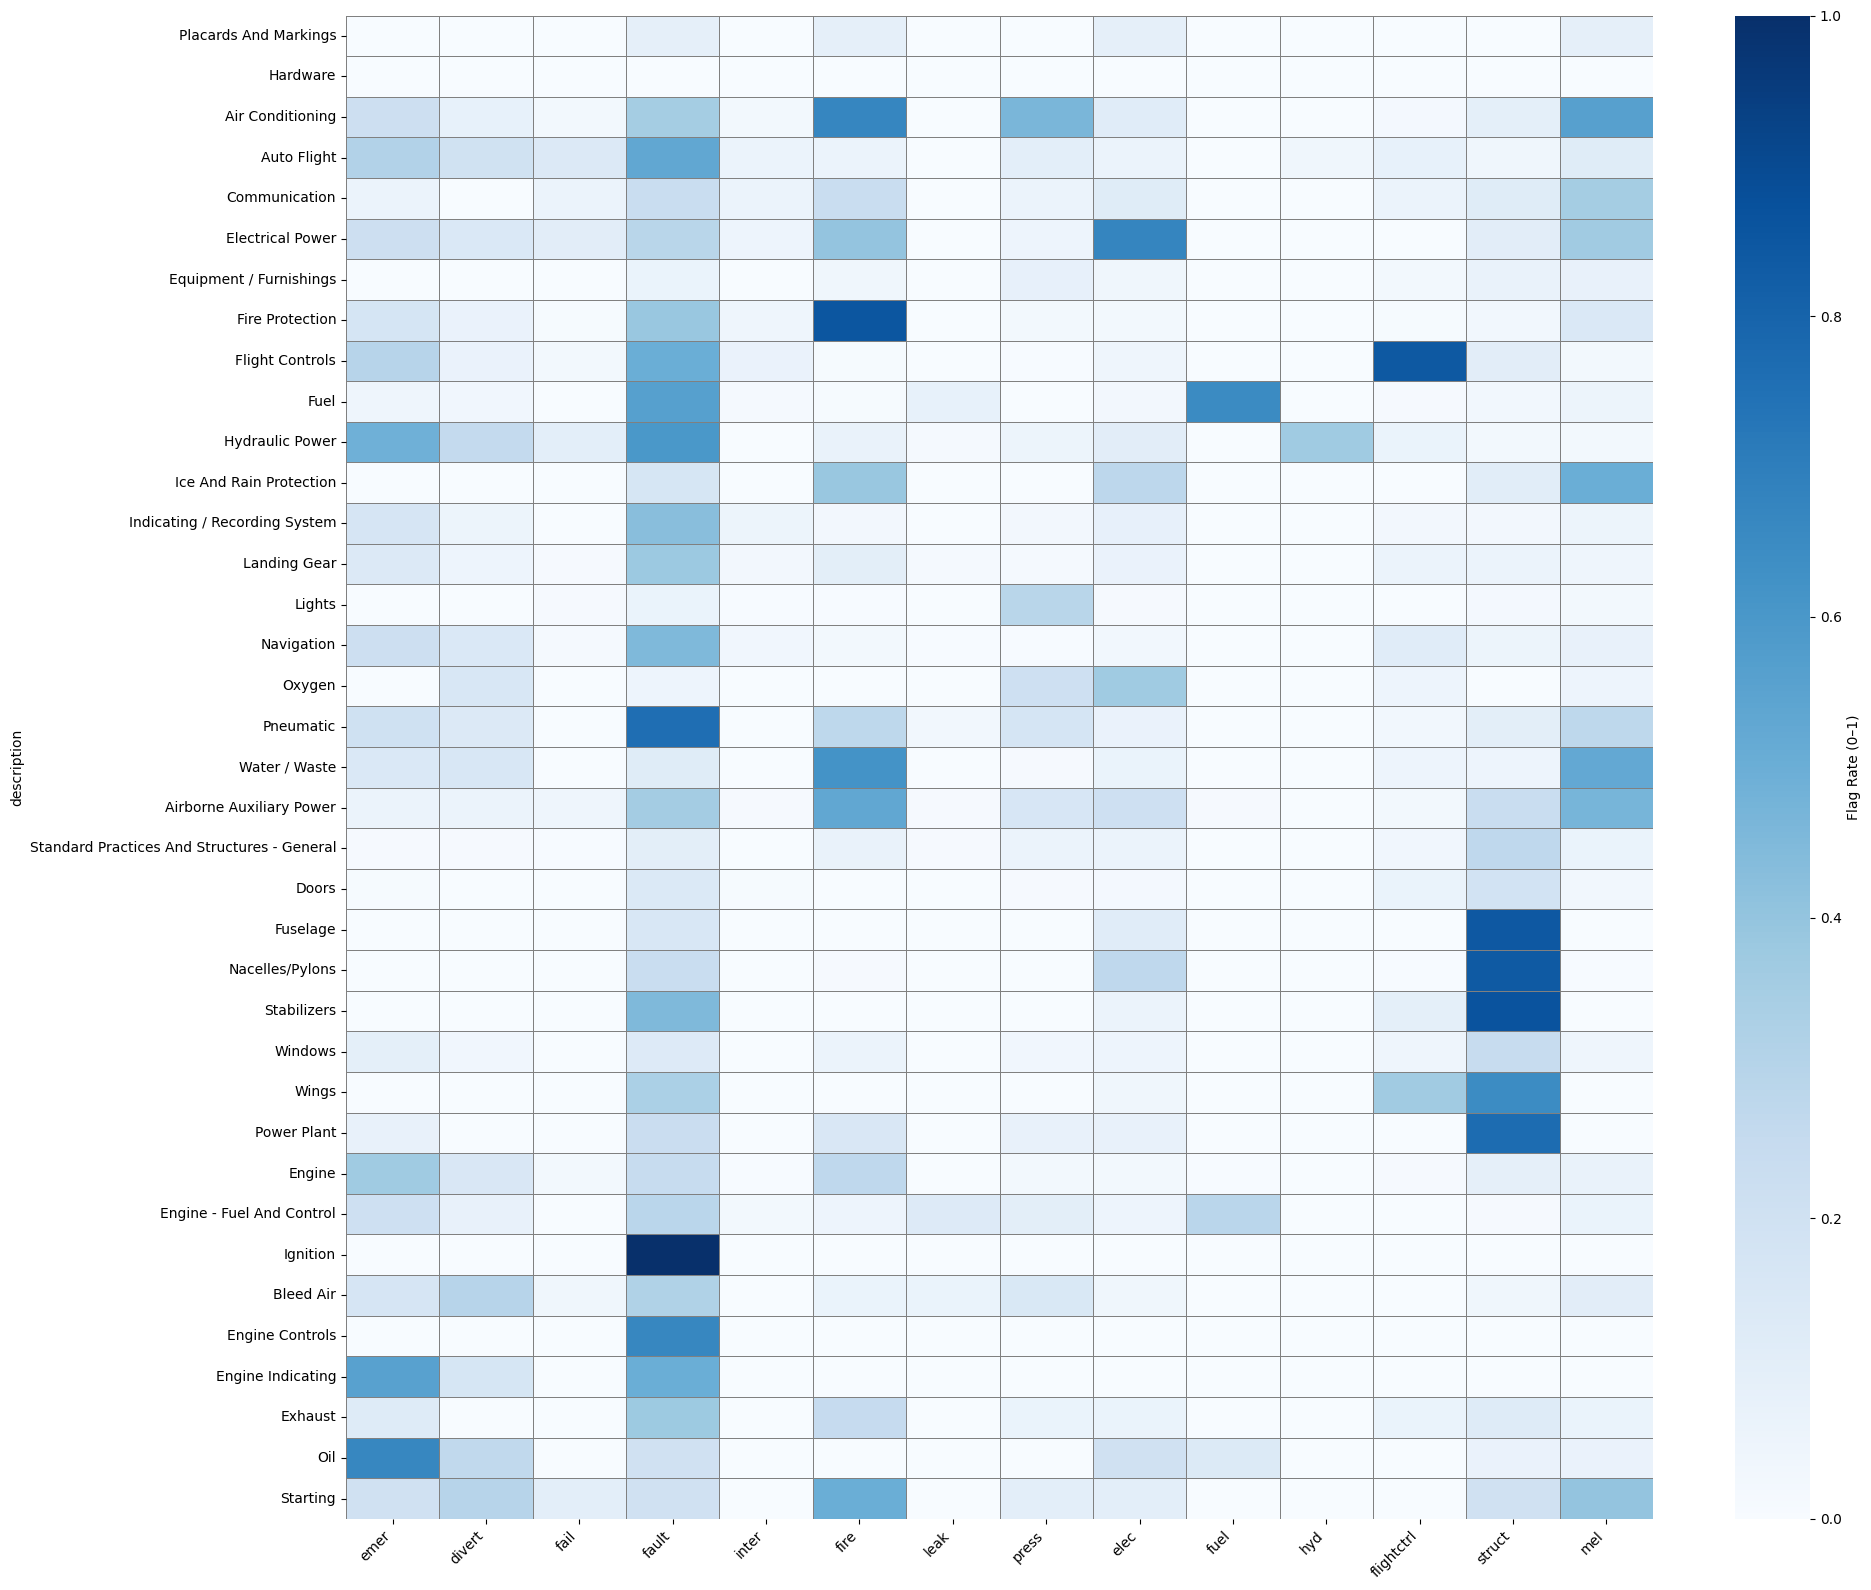

In [34]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from util import sql_python_interface as interface
my_df = interface.q_to_df("""
                        SELECT  a.description,
                                AVG(s.emer_flag::int) AS emer,
                                AVG(s.divert_flag::int) AS divert,
                                AVG(s.fail_flag::int) AS fail,
                                AVG(s.fault_flag::int) AS fault,
                                AVG(s.inter_flag::int) AS inter,
                                AVG(s.fire_flag::int) AS fire,
                                AVG(s.leak_flag::int) AS leak,
                                AVG(s.press_flag::int) AS press,
                                AVG(s.elec_flag::int) AS elec,
                                AVG(s.fuel_flag::int) AS fuel,
                                AVG(s.hyd_flag::int) AS hyd,
                                AVG(s.flightctrl_flag::int) AS flightctrl,
                                AVG(s.struct_flag::int) AS struct,
                                AVG(s.mel_flag::int) AS mel
                        FROM sdr_event AS s
                        INNER JOIN jasc_code AS j
                                ON j.jasc_code = s.jasc_code
                        INNER JOIN ata_chapter AS a
                                ON j.ata_chapter = a.ata_chapter
                        GROUP BY a.ata_chapter
                        ORDER BY a.ata_chapter::int ASC;
                          """)

df_keyword_heatmap = my_df.set_index('description').astype(float)

plt.figure(figsize=(20, 16))  # ← make the plot MUCH bigger BEFORE drawing

ax = sns.heatmap(
    df_keyword_heatmap,
    cmap="Blues",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Flag Rate (0–1)"}
)

# Rotate x-labels so they never overlap
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Ensure y-labels are fully visible
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Expand margins so labels never get cut off
plt.subplots_adjust(
    left=0.35,   # more room for long ATA descriptions
    bottom=0.25, # more room for rotated x-labels
    right=0.95,
    top=0.95
)

plt.tight_layout()
plt.show()

### Keyword x Severity

## Aircraft-Level Analysis
### Events per aircraft

### AOG per aircraft

### Recurrence Intervals

## Structural Analysis
### Crack Length Distribution

### Corrosion Level Distribution

### Strucutral events over time